# Spotify Track Happiness 

For me, and presumably a large part of the world, music is a medium in which we can escape the hardships of reality and sink into a blissful state of euphoria with nothing more than some simple sounds. Likewise we can ruminate in our feelings of longing, lonliness, and grief in the same fashion.

Now more than ever I find myself wandering through moods, feelings, and memories to songs like I have my own soundtrack. So what is it that makes songs feel happy or sad? Am I the only one who likes moody, instrumentals and finds them soothing? Do world events correlate with the mood of songs throughout time? Let's take a closer look to see what Spotify thinks.


#### Questions to Answer:
1) What factors influence happiness?
2) What is the happiest kind of music?
3) What are the happiest songs of all time?
4) Can we predict what will make a song happy?

In [45]:
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import joypy
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 12]

## Data

I grabbed the [Spotify dataset from Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) which has data from the US market. [Spotify's API](https://developer.spotify.com/documentation/web-api/reference/#category-tracks) provides the description of each track feature. The indicator for happiness is denotes as **valence** and is defined as: `A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).` While they don't explicity define their algorithm for determining happiness, we can assume that they got it right ;) . This is ultimately the variable we would like to predict, but let's look at the data before we get started.

In [2]:
# Track and artist data as of April 2021
tracks = pd.read_csv('data/us_market/tracks.csv.gz')

# Genre and year data as of December 2020
genre = pd.read_csv('data/us_market/data_by_genres_o.csv.gz')

In [3]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [69]:
# Need to convert all the `release_date` entries to datetime, not all entries had the year and month of track release.
tracks['release_date'] = pd.to_datetime(tracks['release_date'])
tracks['release_year'] = tracks['release_date'].dt.year

In [58]:
# Also will drop all songs from beore 1920 since there's basically nothing there and it
# makes the plot a little harder to read
tracks = tracks[tracks['release_year'] > pd.to_datetime(1920)]

## How much happiness is there?

For the US market we can look at the **valence** feature, which is: `A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).`

Let's take a look at the distribution of these values.

In [6]:
tracks.describe()['valence']

count    586671.000000
mean          0.552292
std           0.257671
min           0.000000
25%           0.346000
50%           0.564000
75%           0.769000
max           1.000000
Name: valence, dtype: float64

The mean valence for all songs in this dataset is .55 with the minumum being 0 and a max of 1 with a distribution that skews away from low valence songs. 

Let's look at the top 5 most valent songs out there.

In [86]:
tracks.sort_values('valence', ascending=False).head()[['name','artists','popularity']]

,name,artists,popularity
561584,やさしさに包まれたなら,['Full Tone'],42
322002,Loan Er Komin,['Halldor Waren'],18
322066,Voluvisa,['Halldor Waren'],13
51030,Les Petites Marionettes,['Raffi'],43
322093,Lausavisur,['Halldor Waren'],11


For research purposes, let's see what we're working with and grab a song from each quartile. We'll go for the most popular at each quartile.

In [7]:
# The most popular songs with valence of 0
tracks[tracks['valence'] == 0].sort_values('popularity', ascending=False).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
89913,2bRKxuH1o7pTmb1y4GfdEc,Clean White Noise - Loopable with no fade,86,90228,0,"['Erik Eriksson', 'White Noise Baby Sleep', 'W...","['2c5WYCqQGs0UttiLCzVfOe', '4W12lEvVl5wectUtRN...",2017-01-08,0.0,0.00342,...,-28.460,1,0.0,0.791,1.000,0.111,0.0,0.0,0,2017
90054,65rkHetZXO6DQmBh3C2YtW,White Noise - 500 hz,78,147097,0,['Granular'],['1jfnMuDBl5OaAoU0VwLD8m'],2017-10-13,0.0,0.00005,...,-32.354,0,0.0,0.923,0.297,0.110,0.0,0.0,0,2017
90104,6H4B9gJD6eQlNoEh8q85pP,White Noise - 145 hz,77,135484,0,['Granular'],['1jfnMuDBl5OaAoU0VwLD8m'],2017-10-13,0.0,0.00002,...,-40.449,0,0.0,0.944,0.869,0.112,0.0,0.0,0,2017
91234,129ldjjvnFfA7Ygc8ktYnh,Soft Brown Noise,76,160003,0,['High Altitude Samples'],['3T9Rn6sxhCylmpTyWCuu1f'],2018-11-15,0.0,0.00148,...,-31.839,1,0.0,0.394,1.000,0.111,0.0,0.0,0,2018
115632,5pGBDKBaR63vuJ4g8ialcU,Deep Sleep Recovery Noise,75,63000,0,['Water Sound Natural White Noise'],['79Xztd6s33dW9S4V0f4NsQ'],2020-02-25,0.0,0.03200,...,-30.704,1,0.0,0.916,0.202,0.103,0.0,0.0,0,2020


In [8]:
# The most popular songs with valence of 0.35
tracks[tracks['valence'] == .35].sort_values('popularity', ascending=False).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
93079,7AzlLxHn24DxjgQX73F9fU,No Idea,83,154424,0,['Don Toliver'],['4Gso3d4CscCijv0lmajZWs'],2020-03-13,0.652,0.631,...,-5.718,0,0.0893,0.5240,0.000579,0.165,0.35,127.998,4,2020
93265,2QqJTIlGKRLJC3onkavYEz,Flex (feat. Juice WRLD),80,163902,1,"['Polo G', 'Juice WRLD']","['6AgTAQt8XS6jRWi4sX7w49', '4MCBfE4596Uoi2O4Dt...",2020-05-15,0.752,0.673,...,-5.792,0,0.1530,0.0538,0.000000,0.133,0.35,164.009,4,2020
91063,2G7V7zsVDxg1yRsu7Ew9RJ,In My Feelings,79,217925,1,['Drake'],['3TVXtAsR1Inumwj472S9r4'],2018-06-29,0.835,0.626,...,-5.833,1,0.1250,0.0589,0.000060,0.396,0.35,91.030,4,2018
91224,4H7WNRErSbONkM06blBoGc,Stay,76,204427,1,['Post Malone'],['246dkjvS1zLTtiykXe5h60'],2018-04-27,0.507,0.480,...,-5.418,1,0.0266,0.4490,0.000000,0.147,0.35,86.046,4,2018
115781,58w68w4s8h9gw3xrDaXyuj,At My Worst (feat. Kehlani),76,169128,0,"['Pink Sweat$', 'Kehlani']","['1W7FNibLa0O0b572tB2w7t', '0cGUm45nv7Z6M6qdXY...",2021-01-27,0.731,0.484,...,-5.579,1,0.0354,0.7300,0.000003,0.326,0.35,92.043,4,2021


I don't think that noise is a fair play here. Maybe I can get rid of these by limiting some of the other columns, but I'll leave it for now.

In [9]:
# The most popular songs with valence of .56
tracks[tracks['valence'] == .56].sort_values('popularity', ascending=False).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
87969,04aAxqtGp5pv12UXAg4pkq,Centuries,82,228360,0,['Fall Out Boy'],['4UXqAaa6dQYAk18Lv7PEgX'],2015-01-20,0.393,0.858,...,-2.868,0,0.0729,0.003590,0.000000,0.1020,0.56,176.042,4,2015
93662,4ecVWqbtW6phQGpZMAyqIU,Not Shy,77,177728,0,['ITZY'],['2KC9Qb60EaY0kW4eH68vr3'],2020-08-17,0.776,0.911,...,-3.080,0,0.1310,0.155000,0.000003,0.2680,0.56,101.027,4,2020
59495,2MuWTIM3b0YEAskbeeFE1i,Master Of Puppets,75,515387,0,['Metallica'],['2ye2Wgw4gimLv2eAKyk1NB'],1986-03-03,0.543,0.836,...,-9.110,0,0.0353,0.000647,0.431000,0.1530,0.56,105.173,4,1986
115614,2aOK6TRYn4DneIBHJOAQ4r,One More Dance (with Alida),74,145320,0,"['R3HAB', 'Alida']","['6cEuCEZu7PAE9ZSzLLc2oQ', '1kiq2kUV0cbLUhJsr7...",2020-11-13,0.726,0.759,...,-5.107,0,0.0428,0.164000,0.000448,0.0891,0.56,123.923,3,2020
87151,02M6vucOvmRfMxTXDUwRXu,7/11,72,213507,0,['Beyoncé'],['6vWDO969PvNqNYHIOW5v0m'],2014-11-24,0.747,0.705,...,-5.137,0,0.1260,0.012800,0.000000,0.1260,0.56,136.024,4,2014


In [10]:
# The most popular songs with valence of .77
tracks[tracks['valence'] == .77].sort_values('popularity', ascending=False).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
93716,6xZ4Q2k2ompmDppyeESIY8,Level of Concern,77,220051,0,['Twenty One Pilots'],['3YQKmKGau1PzlVlkL1iodx'],2020-04-09,0.754,0.583,...,-7.340,0,0.0432,0.320000,0.00015,0.144,0.77,122.012,4,2020
76422,57Xjny5yNzAcsxnusKmAfA,Reptilia,75,219827,0,['The Strokes'],['0epOFNiUfyON9EYx7Tpr6V'],2003-10-28,0.489,0.649,...,-5.110,1,0.0336,0.000603,0.71300,0.101,0.77,158.009,4,2003
92468,7M2tXmeS15NAzEn7ABFeBg,Homicide (feat. Eminem),75,245387,1,"['Logic', 'Eminem']","['4xRYI6VqpkE3UwrDrAZL8L', '7dGJo4pcD2V6oG8kP0...",2019-05-10,0.694,0.759,...,-5.667,0,0.3980,0.137000,0.00000,0.167,0.77,140.055,4,2019
256583,3ymRYcYHxXMmyvCaKcJ46k,Skyline,74,173945,1,['Ak4:20'],['1SiLK8gdECx2iEm2SSj0Bl'],2020-12-19,0.845,0.642,...,-6.626,1,0.2040,0.277000,0.00000,0.112,0.77,172.008,4,2020
72469,1SWVDBtw6h3tm9OehOkDhv,What's The Difference,72,244200,1,"['Dr. Dre', 'Eminem', 'Xzibit']","['6DPYiyq5kWVQS4RGwxzPC7', '7dGJo4pcD2V6oG8kP0...",1999-11-16,0.772,0.821,...,-0.140,0,0.2500,0.223000,0.00000,0.148,0.77,91.921,4,1999


In [11]:
# The most popular songs with valence of 1
tracks[tracks['valence'] == 1].sort_values('popularity', ascending=False).head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
236547,3rHsX3TLPYixr7eGzRlZqI,Pasito Duranguense,51,200213,0,['Montez de Durango'],['1i4xi4ramy5BPYr2Bhf6sc'],2002-01-04,0.912,0.824,...,-5.163,1,0.0831,0.0776,0.54100,0.0260,1.0,144.925,4,2002
51030,0CgeqYC6ipphjyxgrs1mmZ,Les Petites Marionettes,43,51547,0,['Raffi'],['7oWSqrgMuIEyH9qp5nu2e5'],1977-01-01,0.878,0.255,...,-14.140,1,0.0753,0.3390,0.00001,0.0876,1.0,106.649,4,1977
561584,6UqI7jUTznpqib3q2ZeBvr,やさしさに包まれたなら,42,148562,0,['Full Tone'],['0EQYiwIZqQrwzAvqMhwwQt'],2017-07-12,0.742,0.424,...,-14.106,1,0.0601,0.9750,0.89600,0.0731,1.0,145.989,4,2017
397802,7e3bLyrHNCBH3HnHDpca5a,La carezza della mamma,35,110139,0,['Matteo Bosi'],['0TrrnSs0g46uyEEnvqLv23'],2011-07-01,0.713,0.516,...,-12.752,1,0.0639,0.9960,0.94600,0.0404,1.0,135.067,3,2011
206971,6NcXXqOUOTrqoJvzzFNNB3,Noches Vacias,33,232000,0,['Karolina'],['5UCcU04GZsZJY2g2qmisNp'],1992-01-01,0.753,0.524,...,-15.816,1,0.0531,0.4480,0.47500,0.0399,1.0,105.861,4,1992


Wow, what a spread! The most popular, least valent song was white noise, while the most popular valent song did make me smile!

It's interesting to see that a lot of white noise has a valence of 0. It's hard to say that's actually music but maybe that will provide some insight to what makes a song valent or not? 

Let's look at the most popular happy song before we continue.

Let's look at how the other variables stack up at each quartile of valence.

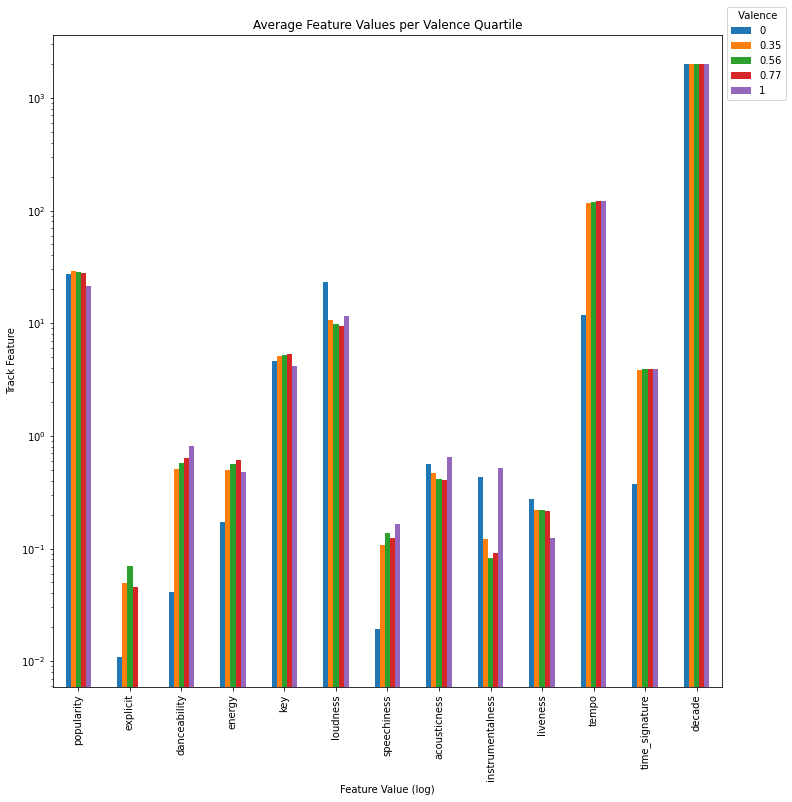

In [70]:
valence_list = []
for i in [0, .35, .56, .77, 1]:
    # Drop the columns that don't scale well with the data or are uninteresting
    valence = pd.DataFrame(tracks[tracks['valence'] == i]
                           .drop(['release_year', 'mode', 
                                  'duration_ms', 'valence'],
                                 axis=1).describe().loc['mean'])
    
    # Name the columns as the valence used to subset
    valence.columns = [str(i)]
    valence_list.append(valence)
    
valence = pd.concat(valence_list, axis=1)

# Since dB are only negative this will need to be the absolute to work in this bar chart.
valence = abs(valence)

valence.plot(rot=90, kind='bar');
plt.yscale('log')
plt.xticks(ticks=range(0,len(valence.index.values)), labels=valence.index.values)
plt.legend(loc=0, bbox_to_anchor=[1,1.05], title=' Valence')
plt.ylabel('Track Feature')
plt.xlabel('Feature Value (log)')
plt.title('Average Feature Values per Valence Quartile');

It seems tempo, time signature, explicit, and speechiness are all low for the least valent songs. We can look at the correlation amongst variables in this dataset to see their relationship to eachother.

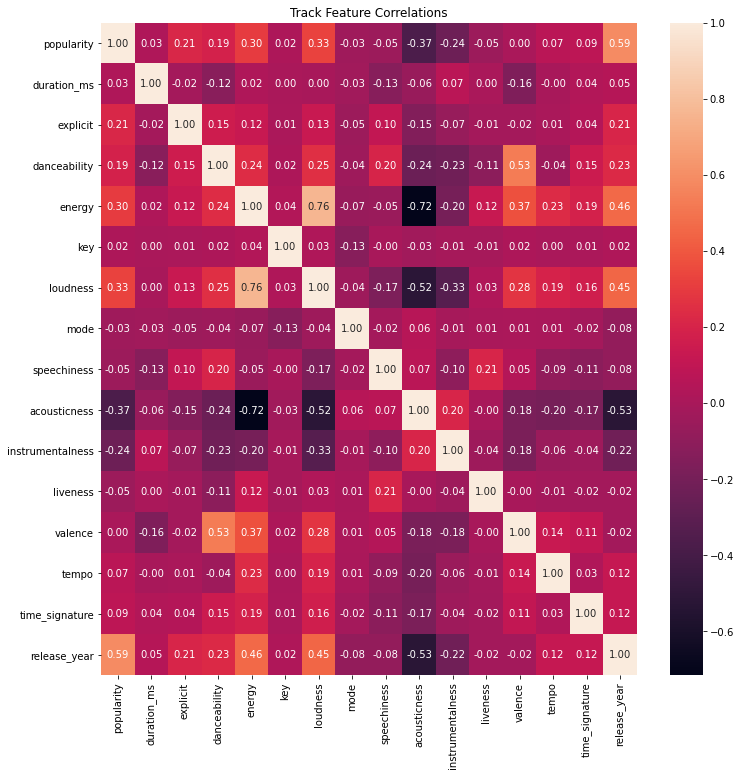

In [13]:
sns.heatmap(tracks.corr(), annot=True, fmt=".2f");
plt.title("Track Feature Correlations");

Acousticness seems to be the most influential variable - it negatively correlates with energy, loudness, release decade, and popularity. 

There also seems to be some bias with respect to popularity and release year. As per the Spotify algorithm definition for calculating popularity:

`The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.`

So if we want to look at popluarity over time we will have to normalize somehow.

Regarding acousticness, the first electric guitar was invented in 1932 while the popularity and availability of solid body electric guitars didn't hit until the 1950s. Could that information help explain the negative correlation of acousticness?

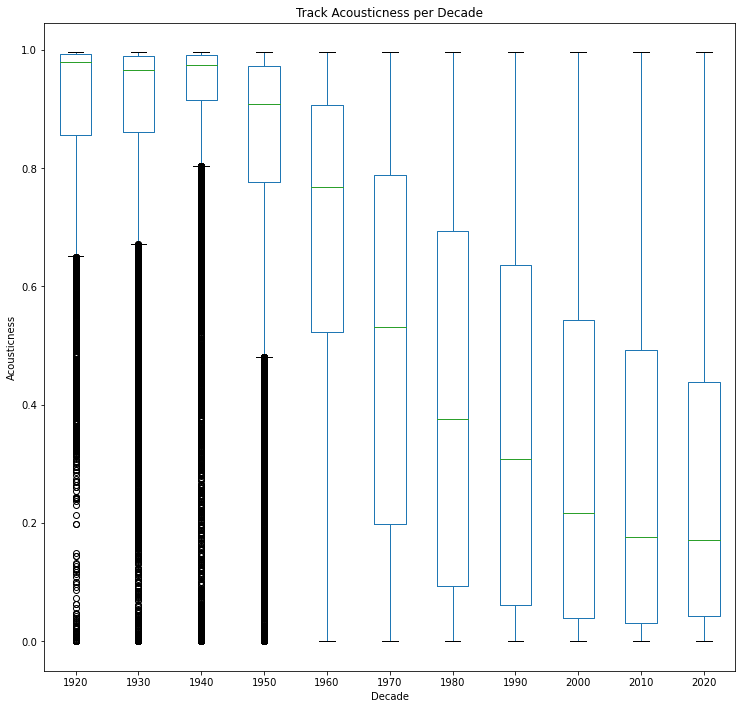

In [71]:
get_decade = lambda x: (int(x)//10)*10
tracks['decade'] = tracks['release_year'].apply(get_decade)
tracks.boxplot(column=['acousticness'], by='decade');
plt.suptitle('');
plt.title('Track Acousticness per Decade');
plt.ylabel('Acousticness');
plt.xlabel('Decade');
plt.grid(False)
plt.savefig('data/figures/track-acousticness-by-decade.jpeg')

This definitely seems to line up with the release electric guitars. I digress..

### Happiness Throughout the Years
I'm interested to see if there are any major world events that could have influenced the happiness of songs for that year. 

To do so I can plot years vs average valence for those songs.

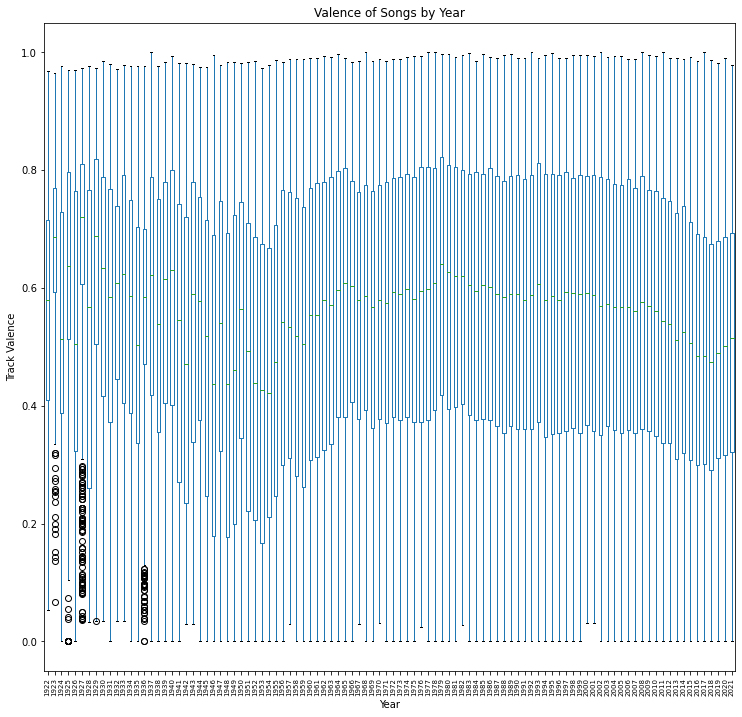

In [72]:
# Grouping by year
plot = tracks.boxplot(column='valence', by='release_year', rot=90)
plt.title("Valence of Songs by Year");
plt.ylabel("Track Valence");
plt.xticks(fontsize=7)
plt.xlabel("Year");
plt.grid(False)
plt.suptitle("")
plt.savefig("data/figures/valence-by-.png", bbox_inches='tight');

This is a bit hard to visualize. though you can clearly see some trends in average valence. Let's break it down by decade to see if that helps!

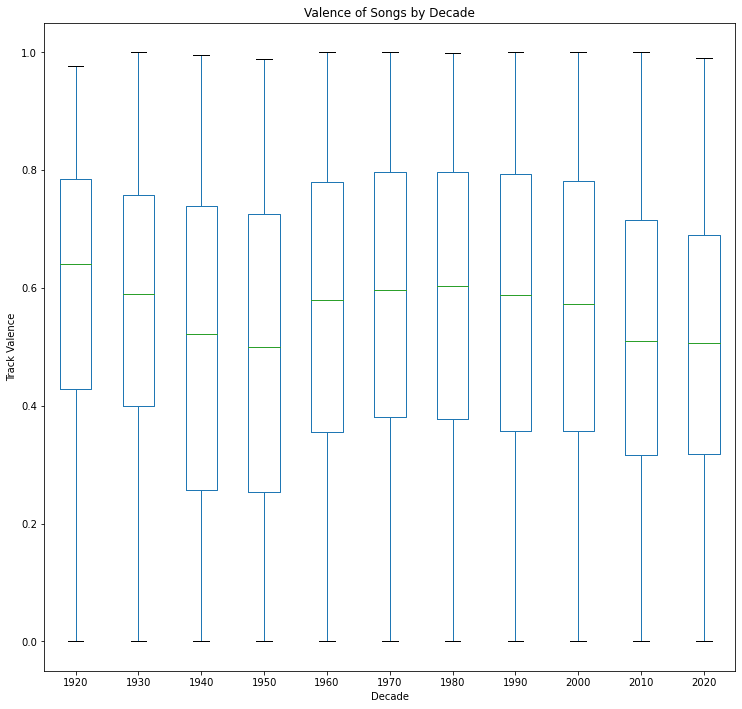

In [47]:
# Grouping by decade
tracks.boxplot(column='valence', by='decade');
plt.title("Valence of Songs by Decade");
plt.ylabel("Track Valence");
plt.xlabel("Decade");
plt.suptitle("");
plt.grid(False)
plt.savefig("data/figures/valence-by-decade.png", bbox_inches='tight');

Interesting! So it seems that there are some fluctuations in the median while the range is more or less the same, with the exceptions being 1920, 1950, and 2020 where the upper bound is slightly less than all the others. There also seems to be no shortage of 0 valence songs throughout time - music really can be therapy!

The two notable dips are during 1940s and 1950s and the most recent decade. Maybe the distributions can tell us a bit more. 

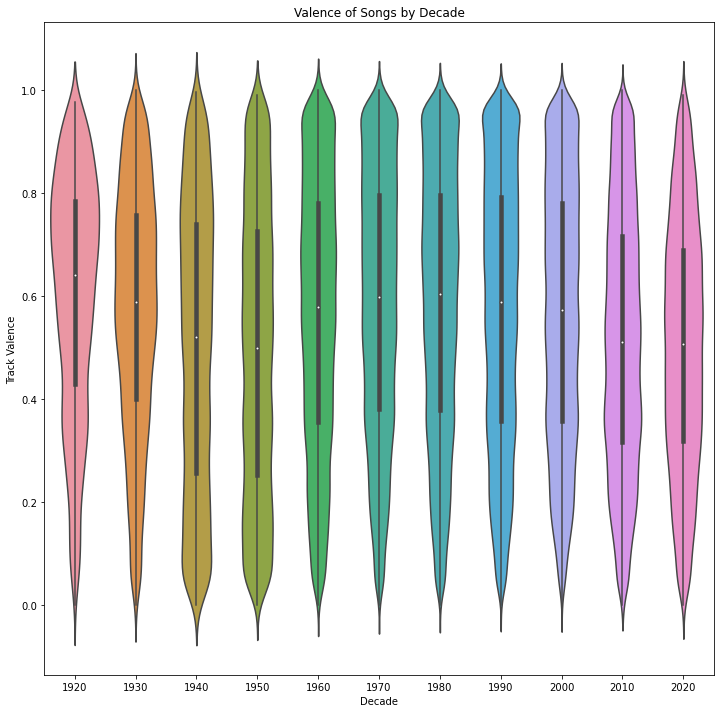

In [74]:
# Grouping by decade
get_decade = lambda x: (x//10)*10
tracks['decade'] = tracks['release_year'].apply(get_decade)
sns.violinplot(y=tracks['valence'], x=tracks['decade'], data=tracks);
plt.title("Valence of Songs by Decade");
plt.ylabel("Track Valence");
plt.xlabel("Decade");
plt.suptitle("");
plt.savefig("data/figures/valence-by-decade-violin.jpeg");

The highest volume of happy songs were in the 1920s while the 1940s and 1950s had significantly more low valence songs while retaining a large amount of high valence songs. To account for the 2010s and 2020s it seems like there's been a shift away from very happy songs to produce more valence-neutral songs.

Let's look at it from one more angle, we can group them by every 5 years and stack them up against eachother.

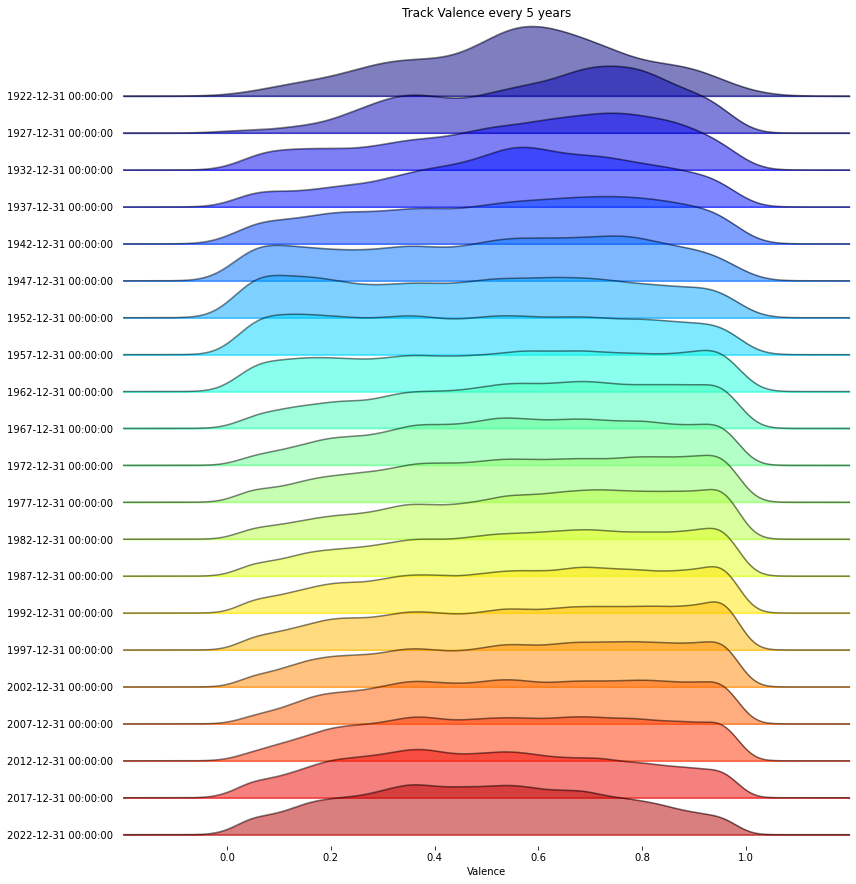

In [76]:
joypy.joyplot(data=tracks, column='valence', by=pd.Grouper(key='release_date', freq='5y'), 
              alpha=0.5,colormap=cm.jet);

plt.title('Track Valence every 5 years');
plt.xlabel('Valence');
plt.ylabel('Quinquennial');
plt.savefig('data/figures/track-valence-quinquennial-joyplot.png', bbox_inches='tight');

The distributions are much more pronounced here. You can see the swing from low valence to high valence that is also aligned with the electric guitar timeline. Maybe the hippy era was really on to somehting! 

Is this a sign that our current culture given up on very happy or very sad music? Are we destined for music that has the same happiness factor as elevator music?! 

Disclaimer: I have no data for the valence of elevator music. 

## The Happiest Songs on Earth

There was an [article](https://www.bostonglobe.com/arts/2015/09/25/neuroscientist-calculates-feel-good-top-playlist/5SjZ0X8WvrztSiQDp1DGfP/story.html) in 2015 with findings by Dr. Jacob Jolji that describes what he considered to be the happiest songs on earth, according to neuroscience. He even created a [playlist](https://open.spotify.com/playlist/7k00dawKjXgBBuq2nZyHmO) with his to 110 happiest songs! Admittedly this is just scratching the surface but he seems to be on to something. Why not check out this playlist to see what these songs look like from a numbers perspective?

In [19]:
def get_track_ids(tracks):
    """Takes a list of spotify track objects and returns a list of track ids
        
    Parameters
    ----------
    tracks : object
        List of track objects
    
    Returns
    -------
   track_ids : list
       List of track ids
    """
    
    track_ids = []
    for track in tracks:
        track_ids.append(track['track']['id'])
    return track_ids

def get_playlist_audio_features(username,playlist_id):
    """Grabs track audio features from a spotify playlist
        
    Parameters
    ----------
    username : str
        Spotify username
    playlist_id : str 
        Spotify playlist id
    
    Returns
    -------
    playlist_audio_features : DataFrame
        Pandas dataframe of all audio features for each track in playlist
    """
    
    features = []
    
    # Returns paginates results
    results = sp.user_playlist_tracks(username,playlist_id)
    
    # Grab features for first page
    tracks = results['items']
    track_ids = get_track_ids(results['items'])
    features.append(pd.DataFrame(sp.audio_features(track_ids)))
    
    # Grab all subsequent pages
    while results['next']:
        results = sp.next(results)
        track_ids = get_track_ids(results['items'])
        features.append(pd.DataFrame(sp.audio_features(track_ids)))
    
    playlist_audio_features = pd.concat(features)
    
    return playlist_audio_features



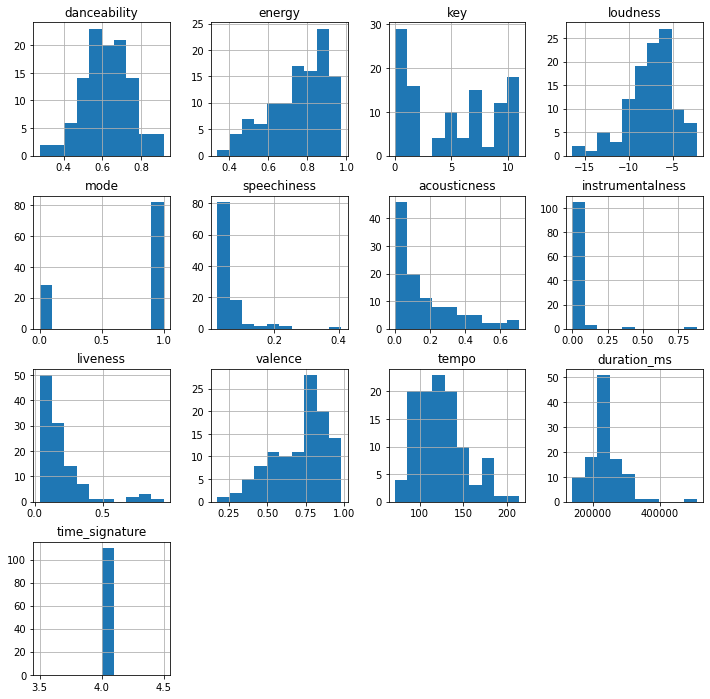

In [20]:
# # # We can use the Spotipy API for grabbing this playlist
# # # I've written the results to 'data/jolji_playlist_track_features.csv' so just read that file in.
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials

# auth_manager = SpotifyClientCredentials(client_id='', 
#                                         client_secret='')
# sp = spotipy.Spotify(auth_manager=auth_manager)
    
# playlist_track_audio_features = get_playlist_audio_features(username='jgoldblum', 
#                                                             playlist_id='7k00dawKjXgBBuq2nZyHmO')

# playlist_track_audio_features.to_csv('data/jolji_playlist_track_features.csv')

playlist_track_audio_features = pd.read_csv('data/jolji_playlist_track_features.csv', index_col=0)

playlist_track_audio_features.hist();

It seems like there may be some signature here, we can make an attempt to train a model to predict happiness using this playlist!

I'm going to clean up the data to retain onnly the info that seems useful: dropping the identifiers, `duration_ms`, and `time_signature`.

In [21]:
# remove useless info
playlist_track_audio_features = playlist_track_audio_features.drop(['type','id', 'uri', 'track_href','analysis_url', 'duration_ms', 'time_signature'], axis=1)
playlist_track_audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.388,0.338,10,-10.054,1,0.0329,0.6520,0.000004,0.248,0.478,177.765
1,0.559,0.868,5,-5.276,1,0.1700,0.0475,0.000176,0.776,0.609,156.295
2,0.396,0.473,10,-7.670,0,0.0345,0.3260,0.000124,0.109,0.385,133.449
3,0.578,0.655,9,-7.935,1,0.0277,0.1210,0.000007,0.137,0.898,101.889
4,0.526,0.775,0,-6.050,1,0.0352,0.7070,0.000021,0.217,0.962,80.106


In [22]:
def get_x_y_datasets(df, y_col, drop_cols=None):
    """Splits dataframe into X and y values for machine learning

    Parameters
    ----------
    df : DataFrame
        Cleanred dataframe
    y_col : str 
        String value of target feature
    drop_cols : list, optional
        Columns to drop from dataframe
    
    Returns
    -------
    X : list of lists
        Features list
    y : list
        Target list
    """

    if drop_cols is None:
        drop_cols = []
        
    drop_cols.append(y_col)
    
    X = df.drop(drop_cols, axis=1)
    y = df[y_col]
    
    return X, y

def run_linear_model(X_train, X_test, y_train, y_test, normalize=True):
    """Runs SKLearn linear regression model
    
    Parameters
    ----------
    X_train : list of lists
        Feature matrix for training
    X_test : list of lists
        Feature matrix for testing
    y_train : list
        Target vector for training
    y_test : list
        Target vector for testing
    normalize : boolean, optional
        Boolean for feature normalization

    Returns
    -------
        y_test_preds : list 
            List of predicted target values (y) for test data
        y_train_preds : list 
            List of redicted target values (y) for training data
        test_r2 : list
            List of test mean squared error (r2) for test predictions
        train_r2 : list
            List of train mean squared error (r2) for train predictions
        lm_model.coef_ : list
            List of feature coefficient values
    """
    
    y_test_preds, y_train_preds, test_score, train_score = [], [], [], []
    

    # Instantiate model
    lm_model = LinearRegression(normalize=normalize) 

    # Fit model
    lm_model.fit(X_train, y_train) 

    # Predict using model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_r2 = r2_score(y_test, y_test_preds)
    train_r2 = r2_score(y_train, y_train_preds)

    return y_test_preds, y_train_preds, test_r2, train_r2, lm_model.coef_

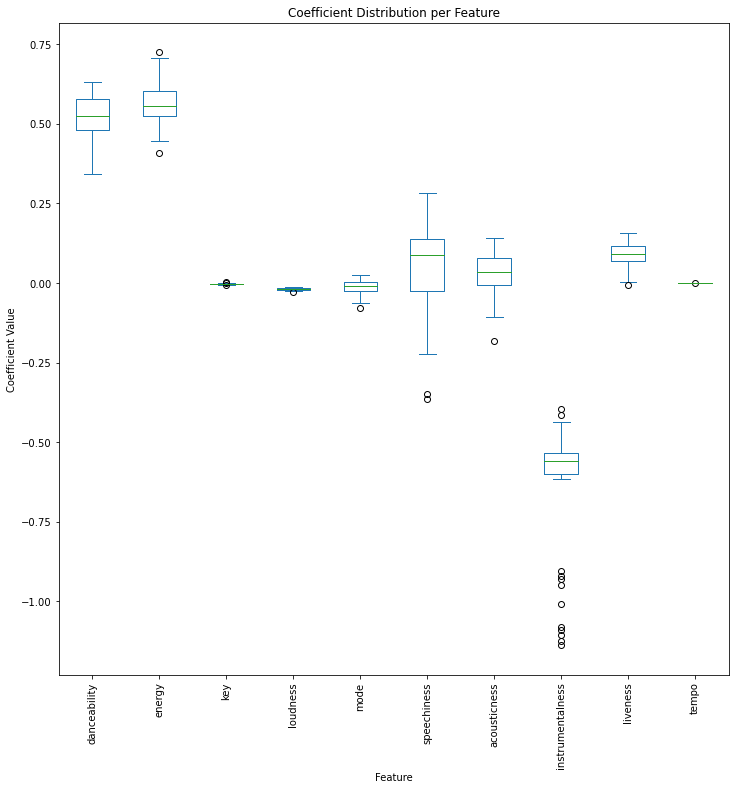

In [103]:
# Drop the features we're not interested in
# Time signature was specified as 4:4 in this playlist so it is a constant and is not required.
X, y = get_x_y_datasets(playlist_track_audio_features, 'valence')
y_test_preds, y_train_preds, test_r2s, train_r2s, coefs = [], [], [], [], []
y_train_data,  y_test_data = [], []

i = 0
while i < 50:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, shuffle=True)
    y_test_pred, y_train_pred, test_r2, train_r2, coef = run_linear_model(X_train, X_test, y_train, y_test)

    y_train_data.append(y_train)
    y_test_data.append(y_test)
    y_test_preds.append(y_test_pred)
    y_train_preds.append(y_train_pred)
    test_r2s.append(test_r2)
    train_r2s.append(train_r2)
    coefs.append(coef)
    
    i += 1

coef_table = pd.DataFrame(columns=X_train.columns.copy())
coef_table = coef_table.append(pd.DataFrame(coefs, columns=X_train.columns.copy()))

coef_table.plot(kind='box')
plt.title('Coefficient Distribution per Feature')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.savefig('data/figures/coefficient-distribution-per-feature.png');

Looking at the distribution of coefficients here it seems there are some that are more significant than others, sepcifically instrumentalness. 

It also seems that tempo has very little effect, as well as the key. Interestingly it seems that despite the strong negative correlation of acousticness there seems to be little effect on valence.

We can take a different look at these relationships by the pairwise comparison and distribution of these features. 

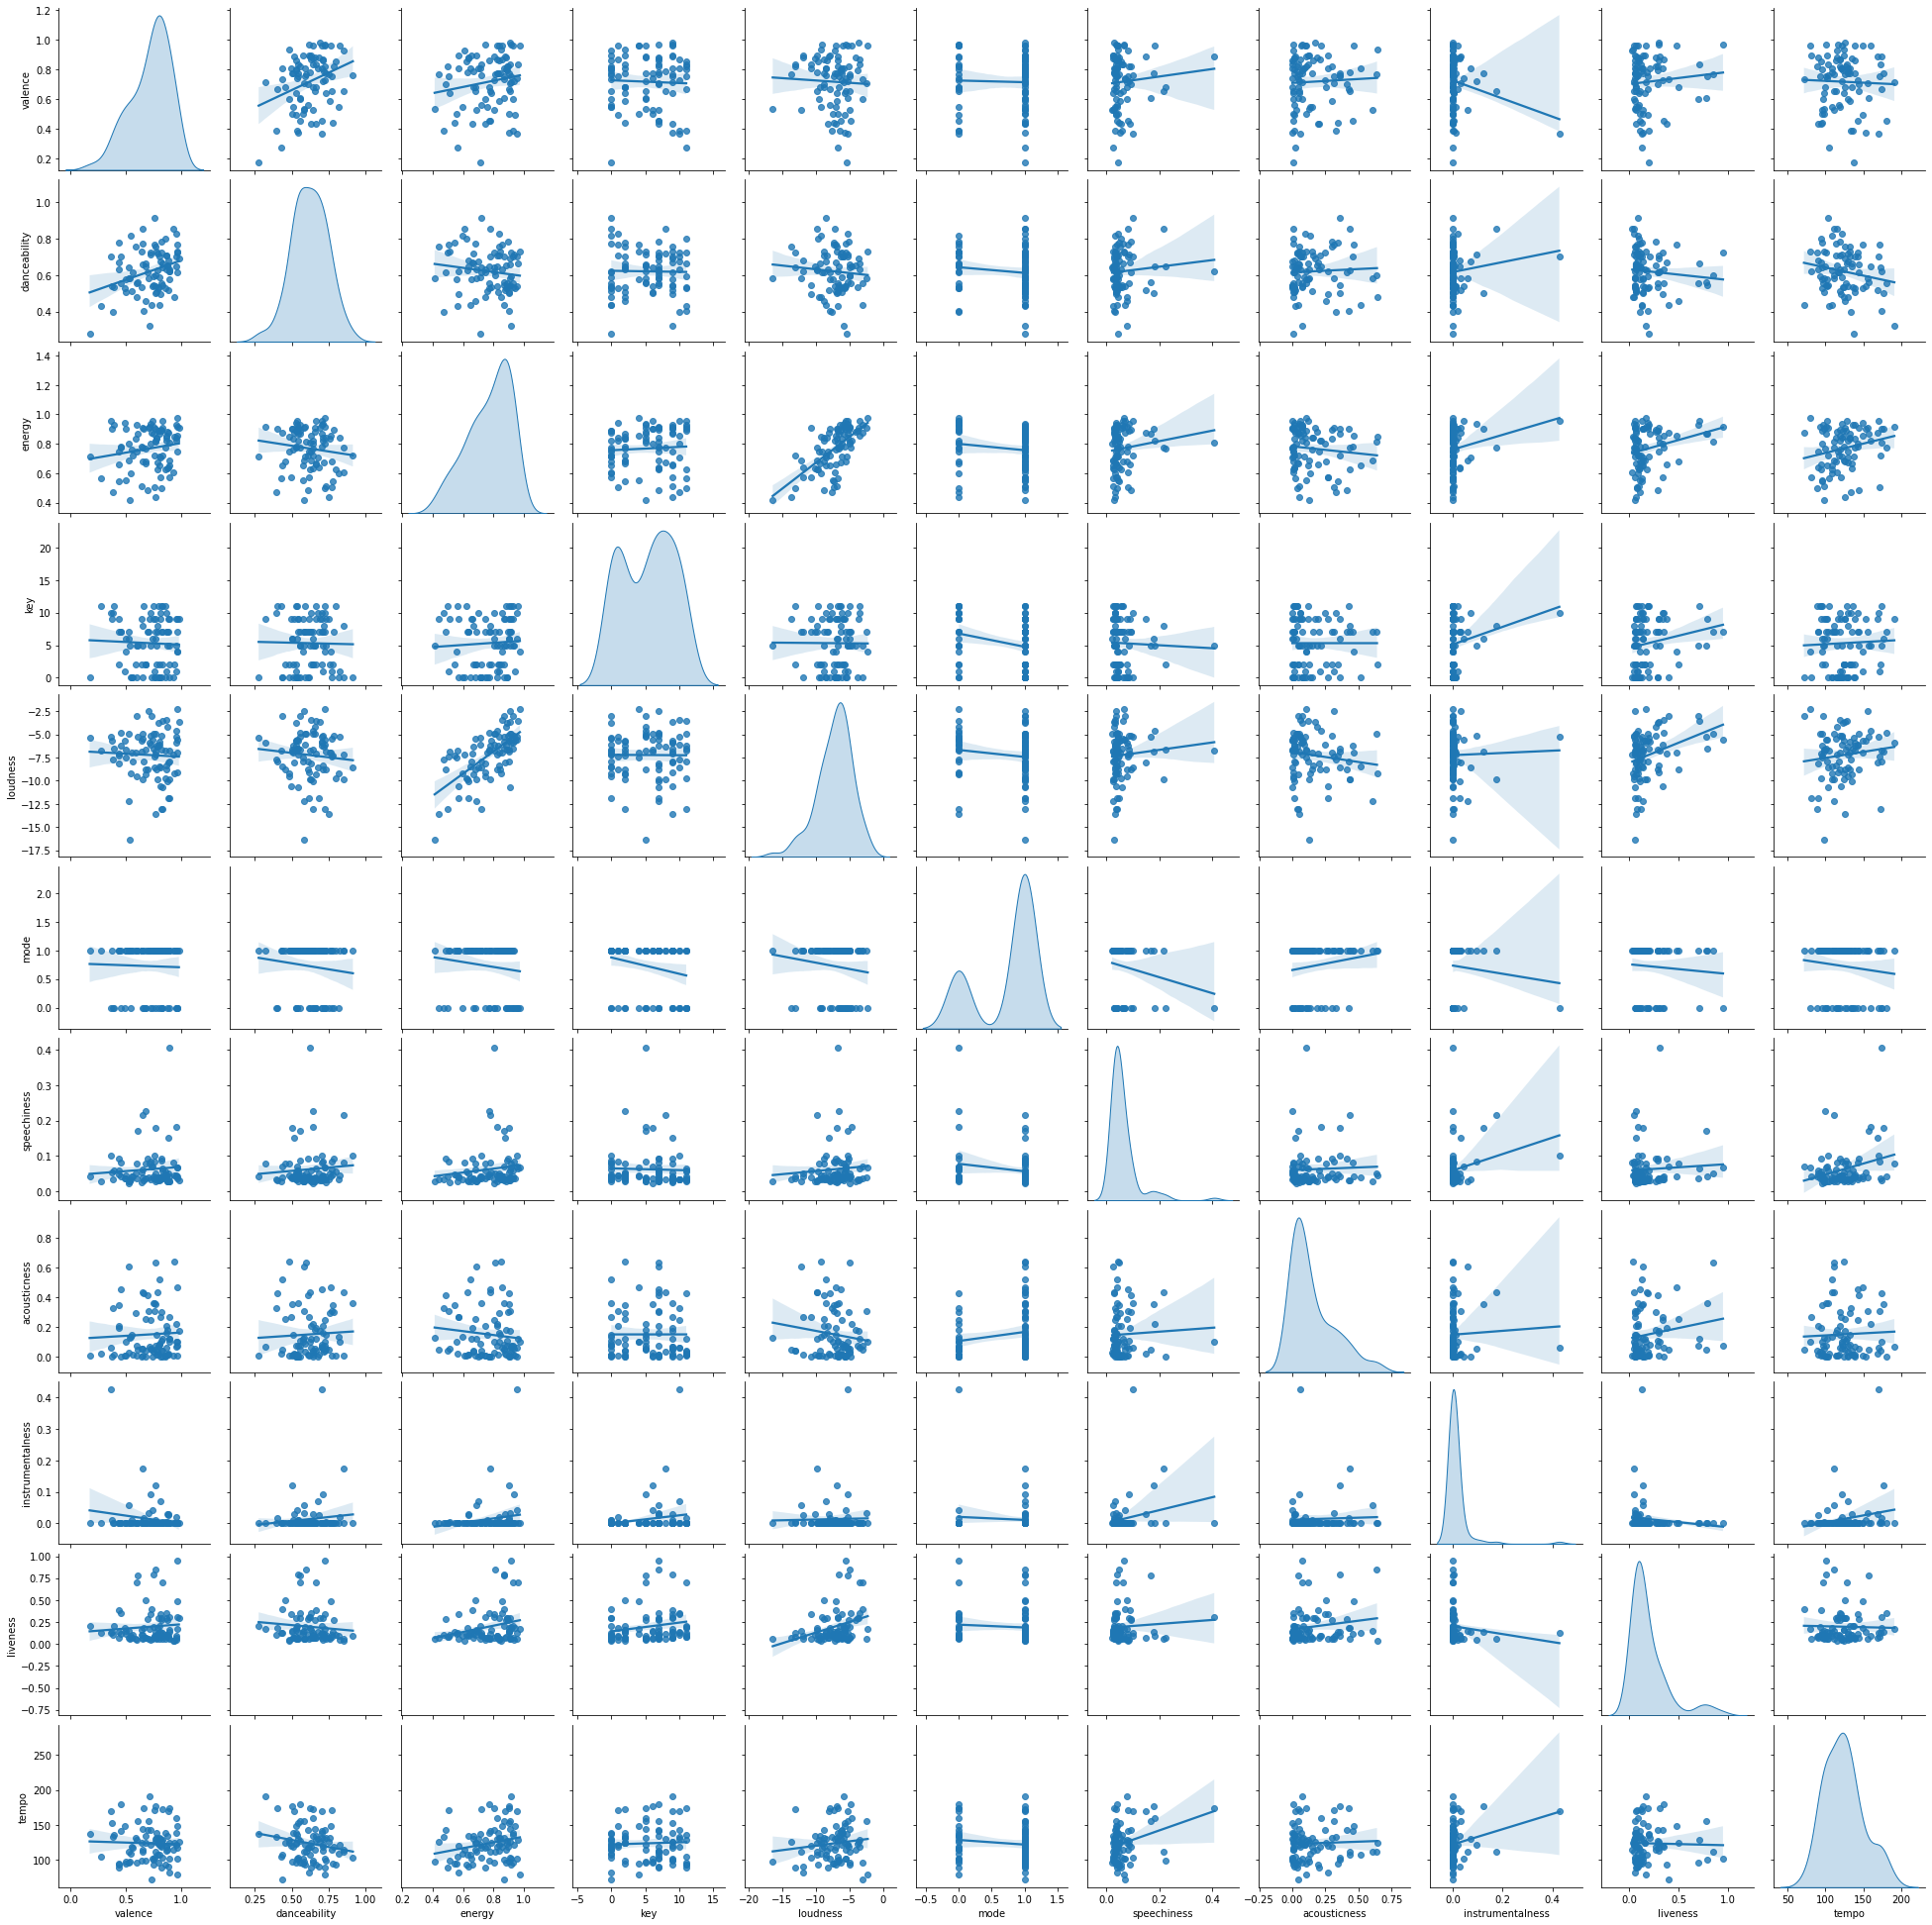

In [24]:
X, y = get_x_y_datasets(playlist_track_audio_features, 'valence')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=42)
train_dataset = X_train.copy()
train_dataset.insert(0, 'valence', y_train)
sns.pairplot(train_dataset, kind='reg', diag_kind='kde');

It seems like there are some variables that may fare better pruned, like instrumentalness, livliness, speechines. 

Before we do that we can check how well our model worked by comparing the r2s values.

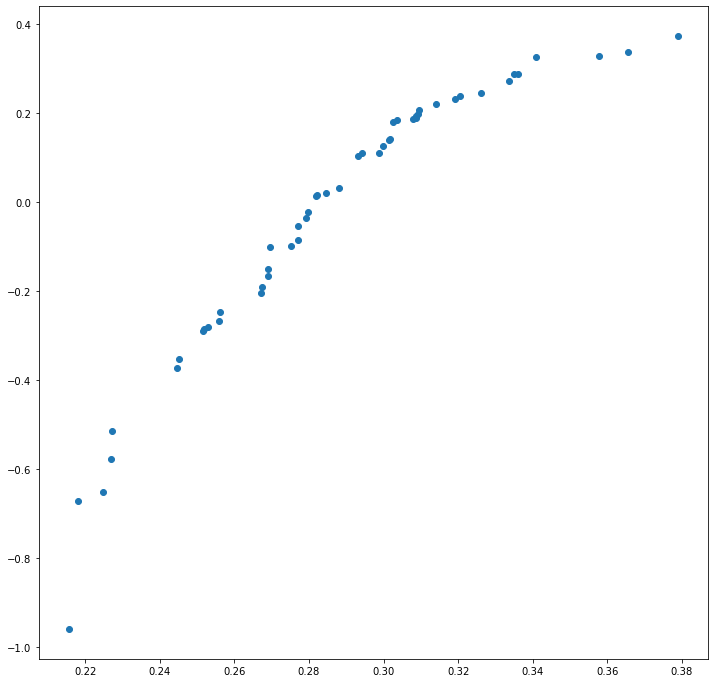

In [105]:
plt.scatter(train_r2s, test_r2s);

In [106]:
np.mean(train_r2s)

0.28806451472482786

In [107]:
np.mean(test_r2s)

-0.02572472541397544

There is definitely a lot of room for improvement. 

### The Happiest Type of Music
Music is classified into genres depending on numerous features. Could it be that certain genres have a certain valence? For example, the blues doesn't usually cheer me up in the same way that I don't know of anyone who is put down by electronic dance music. Let's take a look at the genre data!

In [26]:
genre.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,21st century classical,0.979333,0.162883,1.602977e+05,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6
1,1,432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.500000,5
2,1,8-bit,0.762000,0.712000,1.151770e+05,0.818000,0.876000,0.126000,-9.180000,0.047000,133.444000,0.975000,48.000000,7
3,1,[],0.651417,0.529093,2.328809e+05,0.419146,0.205309,0.218696,-12.288965,0.107872,112.857352,0.513604,20.859882,7
4,1,a cappella,0.676557,0.538961,1.906285e+05,0.316434,0.003003,0.172254,-12.479387,0.082851,112.110362,0.448249,45.820071,7


To do so I first want to see how many generes are recorded.

In [27]:
genre.shape

(2973, 14)

That's quite a few - let's see if we can break it down into key words, or super genres.

In [94]:
genre_str = " ".join(genre['genres'])
wc = WordCloud(width=800, height=800).generate(genre_str)

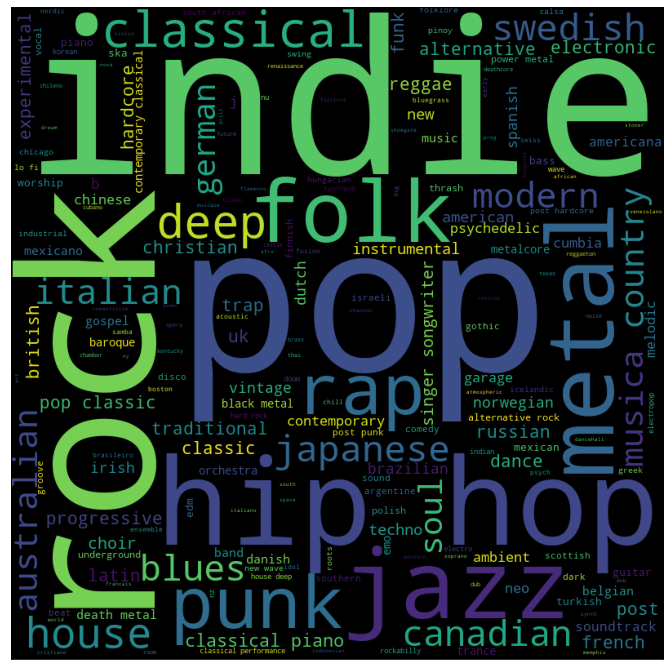

In [100]:
plt.imshow(wc)
plt.xticks([])
plt.yticks([])
plt.savefig('data/figures/genre-wordcloud.png');

I can also make it pretty ;)

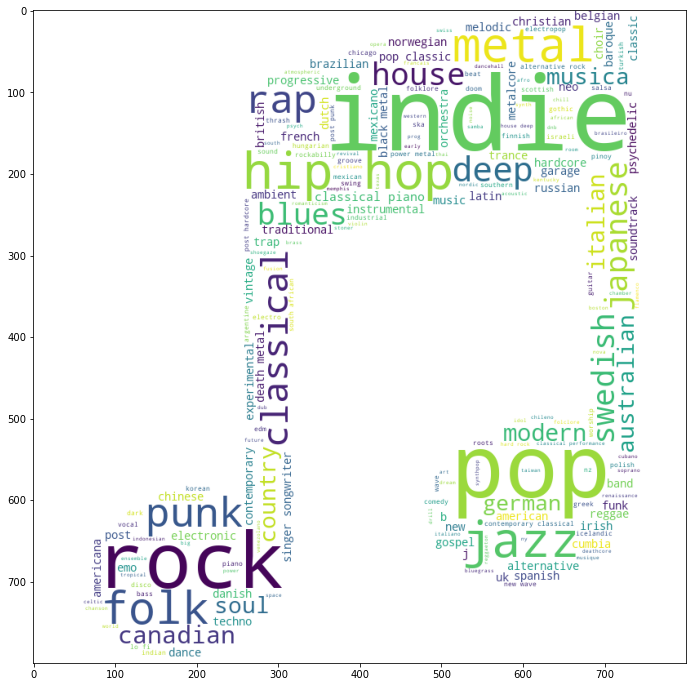

In [91]:
mask = np.array(Image.open('data/Music Note Clip Art 3455.jpg'))
wc = WordCloud(width=800, height=800, mask=mask, background_color='white').generate(genre_str)
plt.imshow(wc);

So it looks like there are a handful of genra that are very common. Let's narrow the playing field a bit by removing the outliers.

In [31]:
genre_df = pd.DataFrame.from_dict(wc.process_text(genre_str), orient='index', columns=['counts'])
genre_df = genre_df[genre_df['counts'] > 40]
genre_df

,counts
classical,55
rock,181
pop,225
punk,69
indie,238
metal,92
rap,66
folk,83
jazz,98
deep,48


This seems good! Let's see the valence for each of these super genres.

In [32]:
# Adding super genre to new column
types = []
for i in genre_df.index:
    temp = pd.DataFrame(genre[genre['genres'].str.contains(i)])
    temp['super_genre'] = i
    types.append(temp)

super_genres = pd.concat(types)
super_genres.head()

,mode,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,super_genre
0,1,21st century classical,0.979333,0.162883,160297.666667,0.071317,0.606834,0.361600,-31.514333,0.040567,75.336500,0.103783,27.833333,6,classical
27,1,african-american classical,0.925534,0.283976,218619.100248,0.142195,0.432027,0.143354,-24.619472,0.058810,132.728932,0.264464,30.649441,5,classical
72,1,american 21st century classical,0.987000,0.155650,254533.000000,0.023950,0.891500,0.096800,-29.108000,0.045100,69.166500,0.047550,46.500000,1,classical
74,1,american classical piano,0.976678,0.355355,298995.267040,0.096571,0.811132,0.136388,-25.651416,0.046699,104.739203,0.246660,24.395569,8,classical
75,1,american contemporary classical,0.938316,0.318150,331714.743172,0.111088,0.481780,0.142994,-25.939671,0.051622,99.853112,0.267309,30.585156,9,classical


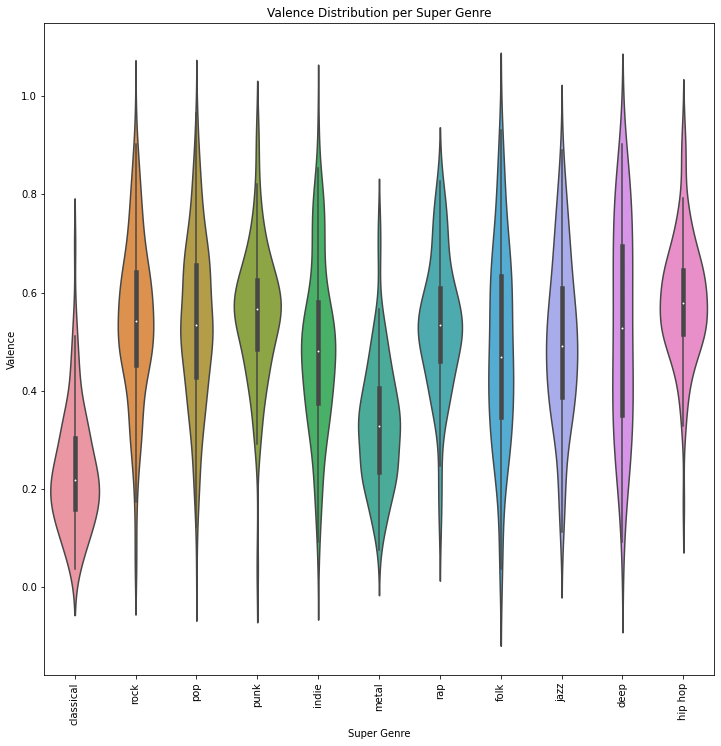

In [101]:
sns.violinplot(y=super_genres['valence'], x=super_genres['super_genre'], data=super_genres)
plt.xticks(rotation=90)
plt.ylabel('Valence')
plt.xlabel('Super Genre')
plt.title('Valence Distribution per Super Genre')
plt.savefig('data/figures/valence_by_super_genre.png');

As a lover of hip hop I would have never guessed it's valence to be so high (the highest mean valence) and classical the least! Well I think we have an answer as to what the happiest type of music is. 

# Conclusion
Though there is still much to do, this analysis provided some very interesting and unexpected insights into how happiness is factored into music. First I think determining feature importance and dimentionality will be most helpful for predicting valence. I also think integrating the genera my help given the genre analysis results. 

## What factors influence happiness?
We were able to identify some of the variables that were correlated within the dataset and we also saw that the introduction of the elctric guitar, as well as some world events, seem to have influenced the overall happiness of music from certain time periods.

## What is the happiest kind of music?
Surprisingly it seems like hip hop is the most valent on average, though you can definitely find more happy songs in folk and deep genres. 

## Can we predict what will make a song happy?
The jury is still out on this one (at least my jury is), but there are some good leads! There needs to be a lot of work on the model, feature selection, and data representation but I will do that in part 2.

## What is the happiest kind of music?
The most valent music on average is hip hop, while the least is classical.

Albeit subjective to the listener I think we can slowly start inching toward what really defines happiness in music which can help make the world a better place!